Trabalho 

In [1]:
import sklearn as skl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prep5 import DataPreparation
from sklearn.metrics import f1_score

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedShuffleSplit
from sklearn import tree

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier, BaggingClassifier, StackingClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.metrics import classification_report
%matplotlib inline

In [2]:
prep = DataPreparation()

train_db = pd.read_csv("dataset/train_radiomics_hipocamp.csv")
test_db = pd.read_csv("dataset/test_radiomics_hipocamp.csv")
control_db = pd.read_csv("dataset/train_radiomics_occipital_CONTROL.csv")

train_db = prep.prep_train(train_db)
test_db = prep.transform(test_db)
control_db = prep.transform(control_db)

In [3]:
train_db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305 entries, 0 to 304
Columns: 2174 entries, diagnostics_Image-original_Dimensionality to diagnostics_Mask-original_CenterOfMass_2
dtypes: float64(2173), object(1)
memory usage: 5.1+ MB


In [4]:
test_db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Columns: 2173 entries, diagnostics_Image-original_Dimensionality to diagnostics_Mask-original_CenterOfMass_2
dtypes: float64(2173)
memory usage: 1.7 MB


In [5]:
X = train_db.drop(columns=["Transition"]) 
y = train_db["Transition"]  

In [6]:
X_train = pd.read_csv('prep5/train_X.csv')
X_test = pd.read_csv('prep5/test_X.csv')
y_train = pd.read_csv('prep5/train_y.csv')
y_test = pd.read_csv('prep5/test_y.csv')

In [9]:
clf = RandomForestClassifier(random_state=2024)

param_grid = {
    'n_estimators': [100,50],          # Número de árvores na floresta
    'max_depth': [5,7],                # Profundidade máxima das árvores
    'min_samples_split': [2,5,10],         # Mínimo de amostras para dividir um nó
    'min_samples_leaf': [2,5,10],           # Mínimo de amostras em uma folha
    'max_features': ['log2','sqrt']         # Número de features a serem consideradas
}


cv_strategy = StratifiedKFold(n_splits=10)

grid_search = GridSearchCV(
    estimator=clf, 
    param_grid=param_grid, 
    scoring='f1_macro',  
    cv=cv_strategy,        
    verbose=1,              
    refit=True,
    n_jobs=-1 
)

grid_search.fit(X, y)

print("Melhores parâmetros encontrados:", grid_search.best_params_)

best_model = grid_search.best_estimator_

print("F1 Score médio com validação cruzada:", grid_search.best_score_)

best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)

print("Matriz de Confusão:")
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')
plt.show()

print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))

Fitting 10 folds for each of 72 candidates, totalling 720 fits
Melhores parâmetros encontrados: {'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
F1 Score médio com validação cruzada: 0.3361018024317257


NameError: name 'X_train' is not defined

F1-Score no conjunto de controle: 0.12762380559313025


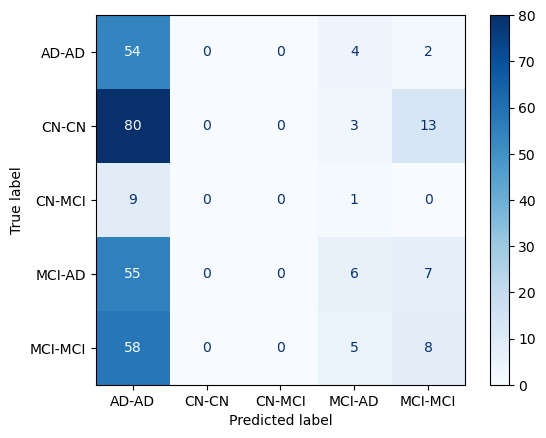


Relatório de Classificação no conjunto de controle:
              precision    recall  f1-score   support

       AD-AD       0.21      0.90      0.34        60
       CN-CN       0.00      0.00      0.00        96
      CN-MCI       0.00      0.00      0.00        10
      MCI-AD       0.32      0.09      0.14        68
     MCI-MCI       0.27      0.11      0.16        71

    accuracy                           0.22       305
   macro avg       0.16      0.22      0.13       305
weighted avg       0.17      0.22      0.13       305



/home/tiagogr/miniconda3/envs/DAA/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tiagogr/miniconda3/envs/DAA/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tiagogr/miniconda3/envs/DAA/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

In [10]:
CX = control_db.drop(columns=["Transition"]) 
Cy = control_db["Transition"]  

control_pred = best_model.predict(CX)

control_f1_score = f1_score(Cy, control_pred, average='macro')
print("F1-Score no conjunto de controle:", control_f1_score)

# Matriz de Confusão
ConfusionMatrixDisplay.from_predictions(Cy, control_pred, cmap='Blues')
plt.show()

# Relatório de Classificação
print("\nRelatório de Classificação no conjunto de controle:")
print(classification_report(Cy, control_pred))

### Guardar o melhor modelo do random forest

In [11]:
best_model.fit(X, y)
test_predictions = best_model.predict(test_db)

row_ids = range(1, len(test_predictions) + 1)

output_df = pd.DataFrame({
    "RowId": row_ids,
    "Result": test_predictions
})


output_df.to_csv("resultados/rf5.csv", index=False)